In [3]:
import os
import pandas as pd
import librosa
from tqdm import tqdm

METADATA_PATH = 'C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/filtered_tracks_metadata.csv'
DATASET_PATH = 'C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large'
MIN_SAMPLES = 22050 * 30  # Minimum required samples, e.g., 30 seconds at 22050 Hz

def downsample_tracks(metadata_path, downsample_ratios):
    """
    Downsamples tracks for each genre according to specified ratios in metadata only.

    Parameters:
        metadata_path (str): Path to the custom metadata CSV file.
        downsample_ratios (dict): Dictionary with genres as keys and downsampling factors (0-1) as values.

    Returns:
        DataFrame: Downsampled DataFrame of tracks.
    """
    # Load the metadata file
    tracks = pd.read_csv(metadata_path, index_col=0)

    # Initialize an empty list to store downsampled DataFrames
    downsampled_dfs = []

    # Loop through each genre and apply downsampling
    for genre, ratio in downsample_ratios.items():
        genre_tracks = tracks[tracks['primary_genre'] == genre]

        # Downsample if ratio < 1, otherwise keep all tracks
        if ratio < 1:
            num_samples = int(len(genre_tracks) * ratio)
            genre_tracks_downsampled = genre_tracks.sample(num_samples, random_state=42)
            print(f"Downsampled {genre} from {len(genre_tracks)} to {len(genre_tracks_downsampled)} tracks")
        else:
            genre_tracks_downsampled = genre_tracks
            print(f"Kept all tracks for {genre} (total: {len(genre_tracks)})")

        downsampled_dfs.append(genre_tracks_downsampled)

    # Combine all downsampled DataFrames
    downsampled_tracks = pd.concat(downsampled_dfs)

    # Display the final count of tracks per genre
    print("\nNumber of tracks per genre after downsampling:")
    print(downsampled_tracks['primary_genre'].value_counts())

    return downsampled_tracks

# Define downsampling ratios for each genre
# downsample_ratios = {
#     'Electronic': 0.078,
#     'Avant-Garde': 0.175,
#     'Experimental': 0.2,
#     'Rock': 0.225,
#     'Pop': 0.26,
#     'Folk': 0.35,
#     'Hip-Hop': 0.37,
#     'Punk': 0.42,
#     'Noise': 0.44,
#     'Lo-Fi': 0.55,
#     'Experimental Pop': 0.55,
#     'Ambient Electronic': 0.74,
#     'Jazz': 0.86,
#     'Classical': 0.90,
#     'International': 0.95,
#     'Blues': 1.0,  # Keep all for Blues
# }
downsample_ratios = {
'Experimental'           :0.013883,
'Avant-Garde'            :0.034118,
'Rock'                   :0.044863,
'Folk'                   :0.045935,
'Hip-Hop'                :0.049383,
'Blues'                   :0.151057,
'Singer-Songwriter'       :0.152905,
'Classical'               :0.177620,
'Techno'                  :0.178571,
'Jazz'                    :0.195695,
'Reggae - Dub'            :0.336700,
'Country'                 :0.341297,
'Metal'                   :0.350877,
'Old-Time / Historic'     :0.534759,
'New Wave'                :0.568182,
'Novelty'                  :1,
}




# Perform downsampling
downsampled_tracks = downsample_tracks(METADATA_PATH, downsample_ratios)

# Optional: Save the downsampled data to a new CSV
downsampled_tracks.to_csv('downsampled_tracks_metadata.csv')





Downsampled Experimental from 7203 to 99 tracks
Downsampled Avant-Garde from 2931 to 99 tracks
Downsampled Rock from 2229 to 99 tracks
Downsampled Folk from 2177 to 100 tracks
Downsampled Hip-Hop from 2025 to 100 tracks
Downsampled Blues from 662 to 99 tracks
Downsampled Singer-Songwriter from 654 to 99 tracks
Downsampled Classical from 563 to 100 tracks
Downsampled Techno from 560 to 99 tracks
Downsampled Jazz from 511 to 100 tracks
Downsampled Reggae - Dub from 297 to 99 tracks
Downsampled Country from 293 to 100 tracks
Downsampled Metal from 285 to 99 tracks
Downsampled Old-Time / Historic from 187 to 99 tracks
Downsampled New Wave from 176 to 100 tracks
Kept all tracks for Novelty (total: 87)

Number of tracks per genre after downsampling:
primary_genre
Folk                   100
Hip-Hop                100
Classical              100
Jazz                   100
Country                100
New Wave               100
Experimental            99
Avant-Garde             99
Rock            

In [1]:
import pandas as pd
import os
import librosa
from tqdm import tqdm

# Paths and settings
METADATA_PATH = 'C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_metadata/fma_metadata/custom_tracks_metadata.csv'
DATASET_PATH = 'C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large'
MIN_SAMPLES = 12000 * 30  # Set the minimum sample threshold (e.g., 30 seconds at 22050 Hz)

def filter_short_tracks(metadata_path, dataset_path, min_samples):
    """
    Filters out tracks with a sample count less than the specified threshold.

    Parameters:
        metadata_path (str): Path to the metadata CSV file.
        dataset_path (str): Path to the directory with audio files.
        min_samples (int): Minimum number of samples required for a track to be included.

    Returns:
        DataFrame: Filtered DataFrame of tracks.
    """
    # Load metadata
    tracks = pd.read_csv(metadata_path, index_col=0)

    # List to store valid track IDs
    valid_tracks = []

    # Progress bar for filtering
    print("Filtering tracks by minimum sample requirement...")
    for track_id in tqdm(tracks.index, desc="Checking track length"):
        folder = f"{int(track_id):03d}"[:3]  # Folder based on track_id
        file_path = os.path.join(dataset_path, folder, f"{track_id}.mp3")

        if os.path.isfile(file_path):
            try:
                # Load audio file and check length
                signal, _ = librosa.load(file_path, sr=None)
                if len(signal) >= min_samples:
                    valid_tracks.append(track_id)  # Track meets minimum sample requirement
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    # Filter metadata to include only valid tracks
    filtered_tracks = tracks.loc[valid_tracks]

    # Display the final count of tracks per genre
    print("\nNumber of tracks per genre after filtering:")
    print(filtered_tracks['primary_genre'].value_counts())

    return filtered_tracks

# Apply filtering
filtered_tracks = filter_short_tracks(METADATA_PATH, DATASET_PATH, MIN_SAMPLES)

# Optional: Save the filtered data to a new CSV
filtered_tracks.to_csv('filtered_tracks_metadata.csv')
print("Filtered metadata saved to 'filtered_tracks_metadata.csv'.")


Filtering tracks by minimum sample requirement...


Checking track length:  57%|████████████████████████████▌                     | 31819/55797 [00:00<00:00, 36284.62it/s]C:\Users\HASSAN\AppData\Local\Temp\ipykernel_26048\3680279564.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, _ = librosa.load(file_path, sr=None)
C:\Users\HASSAN\AppData\Roaming\Python\Python312\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\101\101265.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\101\101272.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\101\101275.mp3: 


Checking track length:  63%|████████████████████████████████▌                   | 34899/55797 [00:20<00:38, 548.52it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\102\102241.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\102\102243.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\102\102247.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\102\102249.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\102\102289.mp3: 


Checking track length:  67%|███████████████████████████████████▊                 | 37656/55797 [02:33<13:07, 23.05it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\109\109266.mp3: 


Checking track length:  68%|████████████████████████████████████                 | 38003/55797 [02:49<13:16, 22.34it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\110\110236.mp3: 


Checking track length:  72%|█████████████████████████████████████▉               | 39966/55797 [04:23<13:23, 19.71it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\115\115610.mp3: 


Checking track length:  73%|██████████████████████████████████████▌              | 40561/55797 [04:51<02:57, 85.84it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\117\117441.mp3: 


Checking track length:  80%|██████████████████████████████████████████▏          | 44371/55797 [07:52<09:32, 19.95it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\126\126981.mp3: 


Checking track length:  80%|██████████████████████████████████████████▍          | 44702/55797 [08:08<09:38, 19.18it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\127\127928.mp3: 


Checking track length:  81%|██████████████████████████████████████████▉          | 45236/55797 [08:35<09:21, 18.79it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\129\129207.mp3: 


Checking track length:  82%|███████████████████████████████████████████▏         | 45488/55797 [08:48<09:01, 19.03it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\129\129800.mp3: 


Checking track length:  82%|███████████████████████████████████████████▍         | 45714/55797 [08:59<08:14, 20.40it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\130\130328.mp3: 


Checking track length:  82%|███████████████████████████████████████████▋         | 45961/55797 [09:10<08:34, 19.12it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\130\130748.mp3: 
Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\130\130751.mp3: 


Checking track length:  84%|████████████████████████████████████████████▋        | 47036/55797 [10:03<07:38, 19.10it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\133\133297.mp3: 


Checking track length:  85%|████████████████████████████████████████████▊        | 47159/55797 [10:09<08:18, 17.33it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\133\133641.mp3: 


Checking track length:  85%|████████████████████████████████████████████▊        | 47165/55797 [10:09<07:59, 18.01it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\133\133647.mp3: 


Checking track length:  91%|████████████████████████████████████████████████▏    | 50720/55797 [13:03<04:11, 20.18it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\142\142614.mp3: 


Checking track length:  92%|████████████████████████████████████████████████▉    | 51489/55797 [13:41<03:40, 19.50it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\143\143992.mp3: 


Checking track length:  95%|██████████████████████████████████████████████████▎  | 52994/55797 [14:57<02:31, 18.54it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\147\147419.mp3: 


Checking track length:  95%|██████████████████████████████████████████████████▎  | 53000/55797 [14:57<02:32, 18.29it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\147\147424.mp3: 


Checking track length: 100%|████████████████████████████████████████████████████▉| 55679/55797 [17:12<00:05, 20.45it/s]

Error loading C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large\155\155051.mp3: 


Checking track length: 100%|█████████████████████████████████████████████████████| 55797/55797 [17:18<00:00, 53.75it/s]


Number of tracks per genre after filtering:
primary_genre
Experimental           7203
Avant-Garde            2931
Rock                   2229
Folk                   2177
Hip-Hop                2025
Blues                   662
Singer-Songwriter       654
Classical               563
Techno                  560
Jazz                    511
Reggae - Dub            297
Country                 293
Metal                   285
Old-Time / Historic     187
New Wave                176
Novelty                  87
Name: count, dtype: int64
Filtered metadata saved to 'filtered_tracks_metadata.csv'.


In [1]:
import json
import os
import math
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# Paths (same as your original)
DATASET_PATH = 'C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/fma_large/fma_large'
METADATA_PATH = 'C:/Users/HASSAN/Desktop/Master Thesis/ClasificacionGeneroMusical_DL-master/ClasificacionGeneroMusical_DL-master/downsampled_tracks_metadata.csv' 
JSON_PATH = "data_fma.json"
SAMPLE_RATE = 12000
TRACK_DURATION = 30  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def print_genre_counts(metadata_path, target_genres=None):
    """Same as your original function"""
    tracks = pd.read_csv(metadata_path, index_col=0)
    if target_genres:
        tracks = tracks[tracks['primary_genre'].isin(target_genres)]
        print(f"Filtered tracks by target genres: {len(tracks)}")
    genre_counts = tracks['primary_genre'].value_counts()
    print("\nNumber of tracks per genre:")
    print(genre_counts)

def load_metadata(metadata_path, dataset_path, target_genres=None):
    """Same as your original function"""
    tracks = pd.read_csv(metadata_path, index_col=0)
    if target_genres:
        tracks = tracks[tracks['primary_genre'].isin(target_genres)]
        print(f"Filtered tracks by target genres: {len(tracks)}")

    available_tracks = set()
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.mp3'):
                track_id = int(os.path.splitext(file)[0])
                available_tracks.add(track_id)

    tracks = tracks[tracks.index.isin(available_tracks)]
    print(f"Tracks after file check: {len(tracks)}")
    return tracks['primary_genre'].dropna()

def save_features(dataset_path, json_path, metadata_path, target_genres, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    """
    Modified version of your save_mfcc() that includes all features while maintaining the same structure
    """
    data = {
        "mapping": target_genres,
        "labels": [],
        "mfcc": [],          # Keeps same structure as original
        "other_features": [] # New: Stores all other features
    }

    genre_data = load_metadata(metadata_path, dataset_path, target_genres)
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    with tqdm(total=len(genre_data), desc="Processing files", unit="file") as pbar:
        for track_id, genre in genre_data.items():
            folder = f"{int(track_id):03d}"[:3]
            file_path = os.path.join(dataset_path, folder, f"{track_id}.mp3")
            
            if os.path.isfile(file_path):
                try:
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                    
                    for d in range(num_segments):
                        start = samples_per_segment * d
                        finish = start + samples_per_segment
                        segment = signal[start:finish]
                        
                        if len(segment) < samples_per_segment:
                            segment = np.pad(segment, (0, samples_per_segment - len(segment)), mode='constant')

                        # Extract MFCCs (same as original)
                        mfcc = librosa.feature.mfcc(y=segment, sr=sample_rate,
                                                  n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T
                        
                        # Extract other features (new)
                        other_features = extract_other_features(segment, sample_rate)
                        
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["other_features"].append(other_features)
                            data["labels"].append(target_genres.index(genre))
                        else:
                            print(f"Skipping segment {d} in {file_path} due to unexpected MFCC shape.")

                    pbar.update(1)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
    print(f"\nFeatures saved to {json_path}")

def extract_other_features(segment, sample_rate):
    """Helper function to extract all non-MFCC features"""
    features = []
    
    # Pitch (Yin algorithm)
    try:
        f0 = librosa.yin(segment, fmin=20, fmax=sample_rate//2)
        f0 = f0[f0 > 0]  # Remove zeros
        features.append(float(np.mean(f0)) if len(f0) > 0 else 0.0)
    except:
        features.append(0.0)
    
    # Tempo
    onset_env = librosa.onset.onset_strength(y=segment, sr=sample_rate)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sample_rate)
    features.append(float(tempo))
    
    # Beats (mean interval)
    _, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sample_rate)
    beats = librosa.frames_to_time(beats, sr=sample_rate)
    if len(beats) > 1:
        features.append(float(np.mean(np.diff(beats))))
    else:
        features.append(0.0)
    
    # Rhythm patterns
    stft = librosa.stft(segment, n_fft=2048, hop_length=512)
    magnitude = np.abs(stft)
    NUM_RHYTHM_BANDS = 6
    band_indices = np.linspace(0, magnitude.shape[0], NUM_RHYTHM_BANDS + 1, dtype=int)
    energy_bands = np.zeros((NUM_RHYTHM_BANDS, magnitude.shape[1]))
    for b in range(NUM_RHYTHM_BANDS):
        energy_bands[b] = np.sum(magnitude[band_indices[b]:band_indices[b+1]], axis=0)
    rhythm_features = []
    for b in range(NUM_RHYTHM_BANDS):
        autocorr = np.correlate(energy_bands[b], energy_bands[b], mode='full')
        rhythm_features.extend(autocorr[len(autocorr)//2:])  # Keep non-negative lags
    features.extend(rhythm_features)
    
    # Chroma features (mean)
    chroma = librosa.feature.chroma_stft(y=segment, sr=sample_rate, n_fft=2048, hop_length=512)
    features.extend(np.mean(chroma, axis=1).tolist())
    
    # RMS dynamics
    rms = librosa.feature.rms(y=segment, frame_length=2048, hop_length=512)[0]
    features.append(float(np.mean(rms)))
    features.append(float(np.std(rms)))
    features.append(float((np.max(rms) - np.min(rms)) / (np.max(rms) + 1e-10)))
    
    return features

def load_data(data_path):
    """Modified to load both MFCCs and other features"""
    with open(data_path, "r") as fp:
        data = json.load(fp)
    
    # MFCCs (same as original)
    X_mfcc = np.array(data["mfcc"])
    
    # Other features (new)
    X_other = np.array(data["other_features"])
    
    y = np.array(data["labels"])
    return X_mfcc, X_other, y

def prepare_datasets(test_size, validation_size):
    """Modified version that maintains your augmentation approach"""
    # Load data
    X_mfcc, X_other, y = load_data(JSON_PATH)
    
    # Split data
    (X_mfcc_train, X_mfcc_test, 
     X_other_train, X_other_test, 
     y_train, y_test) = train_test_split(X_mfcc, X_other, y, test_size=test_size)
    
    (X_mfcc_train, X_mfcc_val, 
     X_other_train, X_other_val, 
     y_train, y_val) = train_test_split(X_mfcc_train, X_other_train, y_train, 
                                      test_size=validation_size)

    # === Data Augmentation (same as your original) ===
    # Reverse MFCCs
    X_mfcc_train_reversed = np.flip(X_mfcc_train, axis=1)
    y_train_reversed = y_train.copy()
    
    # Time shifting
    max_shift = int(0.1 * X_mfcc_train.shape[1])
    X_mfcc_train_shifted = []
    X_other_train_shifted = []
    y_train_shifted = []
    
    for i in range(X_mfcc_train.shape[0]):
        shift = np.random.randint(1, max_shift)
        shifted_mfcc = np.roll(X_mfcc_train[i], shift, axis=1)
        X_mfcc_train_shifted.append(shifted_mfcc)
        X_other_train_shifted.append(X_other_train[i])  # Other features don't get shifted
        y_train_shifted.append(y_train[i])
    
    X_mfcc_train_shifted = np.array(X_mfcc_train_shifted)
    X_other_train_shifted = np.array(X_other_train_shifted)
    y_train_shifted = np.array(y_train_shifted)
    
    # Combine original and augmented data
    X_mfcc_train_augmented = np.concatenate(
        (X_mfcc_train, X_mfcc_train_reversed, X_mfcc_train_shifted), axis=0)
    X_other_train_augmented = np.concatenate(
        (X_other_train, X_other_train, X_other_train_shifted), axis=0)
    y_train_augmented = np.concatenate(
        (y_train, y_train_reversed, y_train_shifted), axis=0)
    
    # Shuffle
    indices = np.arange(X_mfcc_train_augmented.shape[0])
    np.random.shuffle(indices)
    X_mfcc_train_augmented = X_mfcc_train_augmented[indices]
    X_other_train_augmented = X_other_train_augmented[indices]
    y_train_augmented = y_train_augmented[indices]
    
    # Normalize other features
    scaler = StandardScaler()
    X_other_train_augmented = scaler.fit_transform(X_other_train_augmented)
    X_other_val = scaler.transform(X_other_val)
    X_other_test = scaler.transform(X_other_test)
    
    # Add channel dimension to MFCCs
    X_mfcc_train_augmented = X_mfcc_train_augmented[..., np.newaxis]
    X_mfcc_val = X_mfcc_val[..., np.newaxis]
    X_mfcc_test = X_mfcc_test[..., np.newaxis]
    
    return (X_mfcc_train_augmented, X_other_train_augmented), \
           (X_mfcc_val, X_other_val), \
           (X_mfcc_test, X_other_test), \
           y_train_augmented, y_val, y_test

# The rest of your functions (plot_history, predict) remain unchanged

if __name__ == "__main__":
    target_genres = [
        'Experimental', 'Avant-Garde', 'Rock', 'Folk', 'Hip-Hop', 'Blues',
        'Singer-Songwriter', 'Classical', 'Techno', 'Jazz', 'Reggae - Dub', 'Country',
        'Metal', 'Old-Time / Historic', 'New Wave', 'Novelty'
    ]
    
    # Save features (replaces save_mfcc)
    save_features(DATASET_PATH, JSON_PATH, METADATA_PATH, target_genres=target_genres, num_segments=10)
    
    # Prepare datasets
    (X_mfcc_train, X_other_train), (X_mfcc_val, X_other_val), \
    (X_mfcc_test, X_other_test), y_train, y_val, y_test = prepare_datasets(0.25, 0.2)

Filtered tracks by target genres: 1578
Tracks after file check: 1578


Processing files:   0%|                                                                     | 0/1578 [00:00<?, ?file/s]C:\Users\HASSAN\AppData\Local\Temp\ipykernel_4292\2994412888.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
Processing files:   0%|                                                             | 3/1578 [00:05<32:50,  1.25s/file]C:\Users\HASSAN\AppData\Roaming\Python\Python312\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing files: 100%|██████████████████████████████████████████████████████████| 1578/1578 [08:28<00:00,  3.10file/s]



Features saved to data_fma.json


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input (InputLayer)       │ (None, 71, 13, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_12 (Reshape)          │ (None, 71, 13, 1)         │               0 │ mfcc_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_19 (Conv2D)            │ (None, 71, 13, 64)        │             640 │ reshape_12[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ other_input (InputLayer)      │ (None, 444)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_18              │ (None, 36, 7, 64)         │               0 │ conv2d_19[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 64)                │          28,480 │ other_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_19        │ (None, 36, 7, 64)         │             256 │ max_pooling2d_18[0][0]     │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_22        │ (None, 64)                │             256 │ dense_20[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_31 (Dropout)          │ (None, 36, 7, 64)         │               0 │ batch_normalization_19[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 64)                │               0 │ batch_normalization_22[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_20 (Conv2D)            │ (None, 36, 7, 128)        │          73,856 │ dropout_31[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_34 (Dropout)          │ (None, 64)                │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_19              │ (None, 18, 4, 128)        │               0 │ conv2d_20[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_21 (Dense)              │ (None, 128)               │           8,320 │ dropout_34[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_20        │ (None, 18, 4, 128)        │             512 │ max_pooling2d_19[0][0]     │
│ (BatchNormalization)          │                           │               

 Total params: 822,992 (3.14 MB)

 Trainable params: 821,712 (3.13 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/250


C:\Users\HASSAN\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['mfcc_input', 'other_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


888/888 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - accuracy: 0.1162 - loss: 3.2430 - val_accuracy: 0.2395 - val_loss: 2.3955
Epoch 2/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.1816 - loss: 2.5266 - val_accuracy: 0.2357 - val_loss: 2.3196
Epoch 3/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.2222 - loss: 2.3999 - val_accuracy: 0.2640 - val_loss: 2.2315
Epoch 4/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.2442 - loss: 2.3426 - val_accuracy: 0.2725 - val_loss: 2.2496
Epoch 5/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.2639 - loss: 2.2623 - val_accuracy: 0.2784 - val_loss: 2.2344
Epoch 6/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.2839 - loss: 2.2122 - val_accuracy: 0.2987 - val_loss: 2.1721
Epoch 7/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 47s 53ms/step - accuracy: 0.2988 - loss: 2.1613 - val_accuracy: 0.3046 - val_loss: 2.1378
Epoch 8/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.3153 - loss: 2.1171 - val_

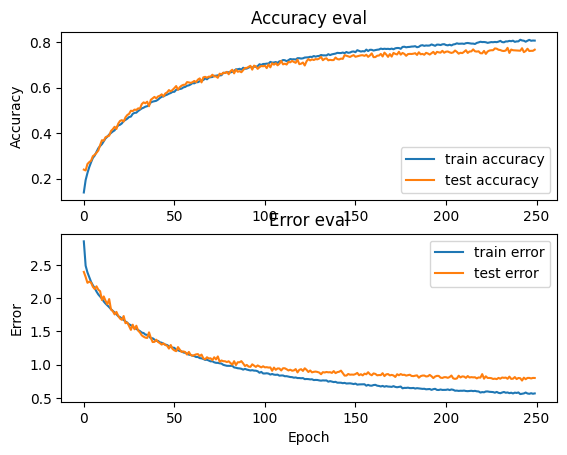

124/124 - 2s - 16ms/step - accuracy: 0.7683 - loss: 0.7927

Test Accuracy: 0.7683
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
Target: 15, Predicted label: [15]


In [10]:
import json
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, 
                                    Dropout, Dense, Flatten, Concatenate, Reshape, Activation)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras as keras


def build_hybrid_model(mfcc_shape, other_features_shape, num_classes=16):
    """Hybrid model with original CNN structure for MFCCs and Dense network for other features"""
    # --- CNN Branch (MFCCs) ---
    mfcc_input = Input(shape=mfcc_shape, name='mfcc_input')
    
    # Reshape MFCCs to (time_steps, 13, 1) for Conv2D
    x = Reshape((mfcc_shape[0], mfcc_shape[1], 1))(mfcc_input)
    
    # Original CNN architecture
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Flatten()(x)
    
    # --- Dense Branch (Other Features) ---
    other_input = Input(shape=(other_features_shape,), name='other_input')
    # Layer 1
    y = Dense(64)(other_input)
    y = BatchNormalization()(y)  # BN before activation
    y = Activation('relu')(y)
    y = Dropout(0.2)(y)
    
    # Layer 2 
    y = Dense(128)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(0.3)(y)
    
    # Layer 3
    y = Dense(128)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(0.4)(y)
    
    # --- Combine Branches ---
    combined = Concatenate()([x, y])
    
    # Final classification layers
    z = Dense(256, activation='relu')(combined)
    z = Dropout(0.5)(z)
    output = Dense(num_classes, activation='softmax')(z)
    
    return Model(inputs=[mfcc_input, other_input], outputs=output)

def plot_history(history):
    """Plots accuracy/loss for training/validation as a function of the epochs."""
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

def predict(model, X_mfcc, X_other, y):
    """Predict a single sample using the trained model."""
    X_mfcc = X_mfcc[np.newaxis, ...]
    X_other = X_other[np.newaxis, ...]
    prediction = model.predict([X_mfcc, X_other])
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Target: {y}, Predicted label: {predicted_index}")

if __name__ == "__main__":
    # Define target genres
    target_genres = [
        'Experimental', 'Avant-Garde', 'Rock', 'Folk', 'Hip-Hop', 'Blues',
        'Singer-Songwriter', 'Classical', 'Techno', 'Jazz', 'Reggae - Dub', 'Country',
        'Metal', 'Old-Time / Historic', 'New Wave', 'Novelty'
    ]

    # Prepare datasets (using your modified prepare_datasets function)
    (X_mfcc_train, X_other_train), (X_mfcc_val, X_other_val), \
    (X_mfcc_test, X_other_test), y_train, y_val, y_test = prepare_datasets(0.25, 0.2)

    # Build model
    mfcc_shape = X_mfcc_train.shape[1:]  # (time_steps, 13)
    other_shape = X_other_train.shape[1]  # num_other_features
    model = build_hybrid_model(mfcc_shape, other_shape)
    
    # Compile with original hyperparameters
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

    # Train with original settings plus early stopping
    history = model.fit(
        [X_mfcc_train, X_other_train], y_train,
        validation_data=([X_mfcc_val, X_other_val], y_val),
        batch_size=32,
        epochs=250,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True)
        ]
    )

    # Plot training history
    plot_history(history)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate([X_mfcc_test, X_other_test], y_test, verbose=2)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    # Make a sample prediction
    sample_idx = 100  # Example index
    predict(model, X_mfcc_test[sample_idx], X_other_test[sample_idx], y_test[sample_idx])

In [12]:
# Predict a sample from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]
predict(model, X_to_predict, y_to_predict)

import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# Load genre labels (mapping) from JSON file
with open(JSON_PATH, "r") as fp:
    data = json.load(fp)
    genre_labels = data["mapping"]

# ================================================
# Confusion Matrix Plotting
# ================================================

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted class labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=genre_labels)  # Use genre names from the mapping
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)

# Set titles and labels
plt.title("Confusion Matrix for Test Set")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.show()

accuracy = accuracy_score(y_test, y_pred_labels)
print(f"\nTest Set Accuracy: {accuracy * 100:.2f}%")

IndexError: tuple index out of range

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input (InputLayer)       │ (None, 71, 13, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_10 (Reshape)          │ (None, 71, 13, 1)         │               0 │ mfcc_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_15 (Conv2D)            │ (None, 71, 13, 64)        │             640 │ reshape_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_15              │ (None, 36, 7, 64)         │               0 │ conv2d_15[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_39        │ (None, 36, 7, 64)         │             256 │ max_pooling2d_15[0][0]     │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_43 (Dropout)          │ (None, 36, 7, 64)         │               0 │ batch_normalization_39[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_16 (Conv2D)            │ (None, 36, 7, 128)        │          73,856 │ dropout_43[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_16              │ (None, 18, 4, 128)        │               0 │ conv2d_16[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_40        │ (None, 18, 4, 128)        │             512 │ max_pooling2d_16[0][0]     │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_44 (Dropout)          │ (None, 18, 4, 128)        │               0 │ batch_normalization_40[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_17 (Conv2D)            │ (None, 18, 4, 128)        │          65,664 │ dropout_44[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ other_input (InputLayer)      │ (None, 444)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_17              │ (None, 9, 2, 128)         │               0 │ conv2d_17[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_11 (Reshape)          │ (None, 71, 13)            │               0 │ mfcc_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 128)               │          56,96

 Total params: 1,002,256 (3.82 MB)

 Trainable params: 1,000,848 (3.82 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/250


C:\Users\HASSAN\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['mfcc_input', 'other_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


888/888 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - accuracy: 0.1204 - loss: 3.2199 - val_accuracy: 0.2112 - val_loss: 2.3915
Epoch 2/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - accuracy: 0.1885 - loss: 2.5061 - val_accuracy: 0.2552 - val_loss: 2.2206
Epoch 3/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - accuracy: 0.2303 - loss: 2.3776 - val_accuracy: 0.2467 - val_loss: 2.2290
Epoch 4/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 51s 58ms/step - accuracy: 0.2598 - loss: 2.2878 - val_accuracy: 0.3071 - val_loss: 2.1276
Epoch 5/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 51s 58ms/step - accuracy: 0.2857 - loss: 2.2129 - val_accuracy: 0.3354 - val_loss: 2.0019
Epoch 6/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 51s 58ms/step - accuracy: 0.2991 - loss: 2.1589 - val_accuracy: 0.3439 - val_loss: 2.0004
Epoch 7/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/step - accuracy: 0.3224 - loss: 2.1085 - val_accuracy: 0.3270 - val_loss: 2.0133
Epoch 8/250
888/888 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/step - accuracy: 0.3361 - loss: 2.0510 - val_

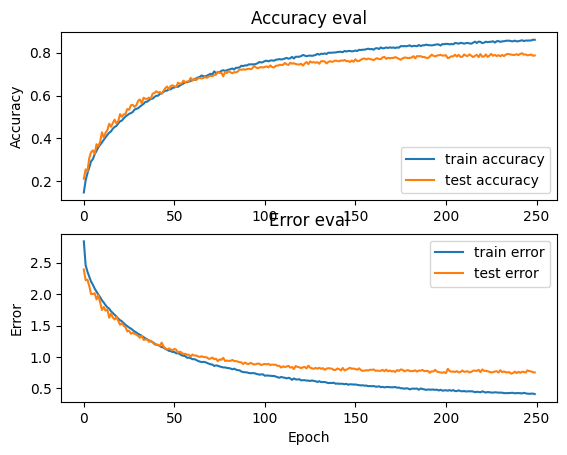

124/124 - 2s - 18ms/step - accuracy: 0.7977 - loss: 0.7351

Test Accuracy: 0.7977
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
Target: 5, Predicted label: [5]


In [7]:
import json
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, 
                                    Dropout, Dense, Flatten, Concatenate, Reshape,
                                    Bidirectional, GRU, Activation)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras as keras

def build_hybrid_parallel_model(mfcc_shape, other_features_shape, num_classes=16):
    """Hybrid model with CNN+BGRU for MFCCs and Dense network for other features"""
    
    # --- MFCC Input Branch (CNN + BGRU) ---
    mfcc_input = Input(shape=mfcc_shape, name='mfcc_input')
    
    # Reshape MFCCs to (time_steps, 13, 1) for Conv2D
    x = Reshape((mfcc_shape[0], mfcc_shape[1], 1))(mfcc_input)
    
    # --- CNN Branch ---
    cnn_branch = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    cnn_branch = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(cnn_branch)
    cnn_branch = BatchNormalization()(cnn_branch)
    cnn_branch = Dropout(0.2)(cnn_branch)
    
    cnn_branch = Conv2D(128, (3, 3), activation='relu', padding='same')(cnn_branch)
    cnn_branch = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(cnn_branch)
    cnn_branch = BatchNormalization()(cnn_branch)
    cnn_branch = Dropout(0.3)(cnn_branch)
    
    cnn_branch = Conv2D(128, (2, 2), activation='relu', padding='same')(cnn_branch)
    cnn_branch = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(cnn_branch)
    cnn_branch = BatchNormalization()(cnn_branch)
    cnn_branch = Dropout(0.4)(cnn_branch)
    
    cnn_branch = Flatten()(cnn_branch)
    
    # --- BGRU Branch ---
    time_steps = mfcc_shape[0]
    features = mfcc_shape[1]  # 13 MFCC coefficients
    reshaped_mfcc = Reshape((time_steps, features))(mfcc_input)
    
    bgru_branch = Bidirectional(GRU(128, return_sequences=False))(reshaped_mfcc)
    bgru_branch = BatchNormalization()(bgru_branch)
    bgru_branch = Dropout(0.4)(bgru_branch)
    
    
    
    
    # --- Other Features Branch ---
    other_input = Input(shape=(other_features_shape,), name='other_input')
    other_branch = Dense(128)(other_input)
    other_branch = BatchNormalization()(other_branch)  # BN before activation
    other_branch = Activation('relu')(other_branch)
    other_branch = Dropout(0.4)(other_branch)
    
    # Layer 2 
    

    
    # --- Combine All Branches ---
    combined = Concatenate()([cnn_branch, bgru_branch, other_branch])
    
    # Final classification layers
    dense = Dense(256, activation='relu')(combined)
    dense = Dropout(0.5)(dense)
    output = Dense(num_classes, activation='softmax')(dense)
    
    return Model(inputs=[mfcc_input, other_input], outputs=output)

def plot_history(history):
    """Plots accuracy/loss for training/validation as a function of the epochs."""
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

def predict(model, X_mfcc, X_other, y):
    """Predict a single sample using the trained model."""
    X_mfcc = X_mfcc[np.newaxis, ...]
    X_other = X_other[np.newaxis, ...]
    prediction = model.predict([X_mfcc, X_other])
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Target: {y}, Predicted label: {predicted_index}")

if __name__ == "__main__":
    # Define target genres
    target_genres = [
        'Experimental', 'Avant-Garde', 'Rock', 'Folk', 'Hip-Hop', 'Blues',
        'Singer-Songwriter', 'Classical', 'Techno', 'Jazz', 'Reggae - Dub', 'Country',
        'Metal', 'Old-Time / Historic', 'New Wave', 'Novelty'
    ]

    # Prepare datasets (using your modified prepare_datasets function)
    (X_mfcc_train, X_other_train), (X_mfcc_val, X_other_val), \
    (X_mfcc_test, X_other_test), y_train, y_val, y_test = prepare_datasets(0.25, 0.2)

    # Build model
    mfcc_shape = X_mfcc_train.shape[1:]  # (time_steps, 13)
    other_shape = X_other_train.shape[1]  # num_other_features
    model = build_hybrid_parallel_model(mfcc_shape, other_shape)
    
    # Compile with original hyperparameters
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

    # Train with original settings plus early stopping
    history = model.fit(
        [X_mfcc_train, X_other_train], y_train,
        validation_data=([X_mfcc_val, X_other_val], y_val),
        batch_size=32,
        epochs=250,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)
        ]
    )

    # Plot training history
    plot_history(history)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate([X_mfcc_test, X_other_test], y_test, verbose=2)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    # Make a sample prediction
    sample_idx = 100  # Example index
    predict(model, X_mfcc_test[sample_idx], X_other_test[sample_idx], y_test[sample_idx])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Target: 5, Predicted label: [5]
True Genre: Blues
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Genre: Blues
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


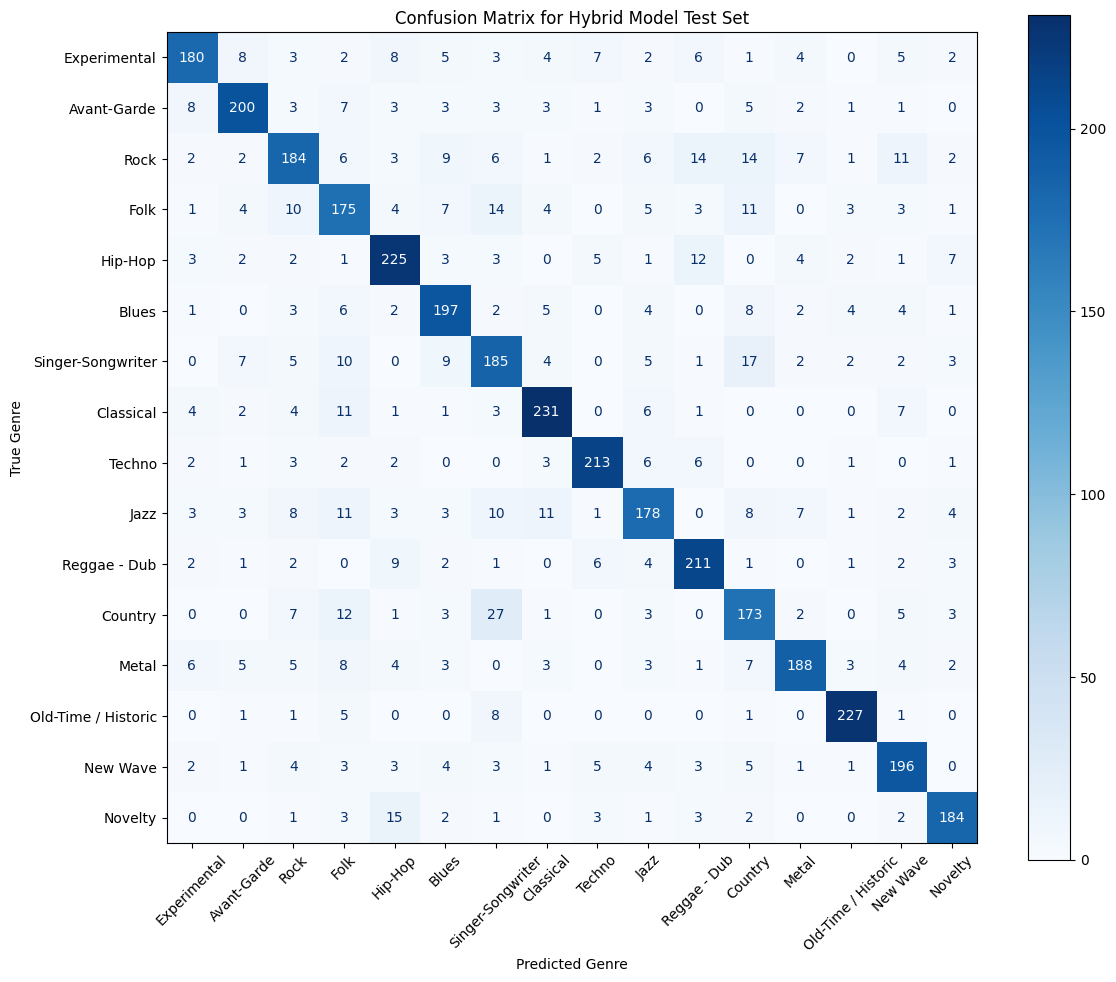


Test Set Accuracy: 79.77%

Classification Report:
                     precision    recall  f1-score   support

       Experimental       0.84      0.75      0.79       240
        Avant-Garde       0.84      0.82      0.83       243
               Rock       0.75      0.68      0.71       270
               Folk       0.67      0.71      0.69       245
            Hip-Hop       0.80      0.83      0.81       271
              Blues       0.78      0.82      0.80       239
  Singer-Songwriter       0.69      0.73      0.71       252
          Classical       0.85      0.85      0.85       271
             Techno       0.88      0.89      0.88       240
               Jazz       0.77      0.70      0.74       253
       Reggae - Dub       0.81      0.86      0.83       245
            Country       0.68      0.73      0.71       237
              Metal       0.86      0.78      0.82       242
Old-Time / Historic       0.92      0.93      0.92       244
           New Wave       0.80   

In [8]:
# Predict a sample from the test set
sample_idx = 100  # Example index

# For hybrid model (two inputs)
X_mfcc_to_predict = X_mfcc_test[sample_idx]  # MFCC features 
X_other_to_predict = X_other_test[sample_idx]  # Other features
y_to_predict = y_test[sample_idx]

# Use your existing predict function
predict(model, X_mfcc_to_predict, X_other_to_predict, y_to_predict)

# To show genre names instead of indices:
with open(JSON_PATH, "r") as fp:
    genre_labels = json.load(fp)["mapping"]
print(f"True Genre: {genre_labels[y_to_predict]}")
print(f"Predicted Genre: {genre_labels[np.argmax(model.predict([
    X_mfcc_to_predict[np.newaxis, ...],
    X_other_to_predict[np.newaxis, ...]
]), axis=1)[0]]}")

import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Load genre labels
with open(JSON_PATH, "r") as fp:
    genre_labels = json.load(fp)["mapping"]

# Generate predictions for the test set (for hybrid model)
y_pred = model.predict([X_mfcc_test, X_other_test])  # Pass both inputs
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))  # Larger size for readability
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=genre_labels
)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)

# Adjust layout and labels
plt.title("Confusion Matrix for Hybrid Model Test Set")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.tight_layout()  # Prevent label cutoff
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"\nTest Set Accuracy: {accuracy * 100:.2f}%")

# Optional: Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=genre_labels))

In [4]:
import json
import os
import math
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, Concatenate
from tensorflow.keras.layers import PReLU, Layer, BatchNormalization
from tqdm import tqdm
import tensorflow as tf

# Configurations - Added USE_BATCH_NORM flag
class Config:
    MCLNN_LAYER_COUNT = 3
    DENSE_LAYER_COUNT = 2
    TOTAL_LAYER_COUNT = MCLNN_LAYER_COUNT + DENSE_LAYER_COUNT
    HIDDEN_NODES_LIST = [220, 200, 180]
    OTHER_FEATURES_NODES = [128, 64]
    DENSE_NODES = [50, 16]
    MASK_BANDWIDTH = [40, 10, 5]
    MASK_OVERLAP = [-10, 3, 1]
    LAYERS_ORDER_LIST = [4, 4, 4]
    LAYER_IS_MASKED = [True, True, True]
    DROPOUT = [0.01, 0.4, 0.2, 0.1, 0.2]
    OTHER_FEATURES_DROPOUT = [0.15, 0.15]
    WEIGHT_INITIALIZATION = ['he_normal', 'he_normal', 'he_normal', 'glorot_uniform', 'glorot_uniform']
    LEARNING_RATE = 0.0001
    USE_BATCH_NORM = True  # New flag to control batch normalization

# MaskedConditional Layer (unchanged)
class MaskedConditional(Layer):
    def __init__(self, output_dim, init='glorot_uniform', order=5, bandwidth=1, overlap=0, layer_is_masked=True, **kwargs):
        super(MaskedConditional, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.init = keras.initializers.get(init)
        self.order = order
        self.bandwidth = bandwidth
        self.overlap = overlap
        self.layer_is_masked = layer_is_masked

    def build(self, input_shape):
        input_dim = input_shape[-1]
        kernel_size = self.order * 2 + 1
        self.kernel_size = kernel_size

        self.W = self.add_weight(
            shape=(kernel_size, input_dim, self.output_dim),
            initializer=self.init,
            trainable=True,
            name='weights'
        )
        self.b = self.add_weight(
            shape=(self.output_dim,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

        self.weightmask = self.construct_mask(
            input_dim, self.output_dim, self.bandwidth, self.overlap, self.layer_is_masked
        )
        self.weightmask = tf.expand_dims(self.weightmask, axis=0)
        self.weightmask = tf.tile(self.weightmask, [kernel_size, 1, 1])
        self.W.assign(self.W * self.weightmask)

        super(MaskedConditional, self).build(input_shape)

    def construct_mask(self, feature_count, hidden_count, bandwidth, overlap, layer_is_masked):
        bw = bandwidth
        ov = overlap
        l = feature_count
        e = hidden_count

        a = np.arange(1, bw + 1)
        g = np.arange(1, int(np.ceil((l * e) / (l + bw - ov))) + 1)

        if not layer_is_masked:
            binary_mask = np.ones([l, e])
        else:
            mask = np.zeros([l, e])
            flat_matrix = mask.flatten('F')

            for i in range(len(a)):
                for j in range(len(g)):
                    lx = a[i] + (g[j] - 1) * (l + bw - ov)
                    if lx <= l * e:
                        flat_matrix[lx - 1] = 1

            binary_mask = np.transpose(flat_matrix.reshape(e, l))

        return binary_mask.astype(np.float32)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        sequence_length = tf.shape(inputs)[1]
        feature_count = tf.shape(inputs)[2]

        padding = self.order
        padded_inputs = tf.pad(inputs, [[0, 0], [padding, padding], [0, 0]], mode='CONSTANT')

        outputs = tf.nn.conv1d(padded_inputs, self.W, stride=1, padding='VALID')
        outputs = outputs + self.b
        return outputs

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_dim)

# Updated build_parallel_model with BatchNormalization
def build_parallel_model(mfcc_shape, other_features_dim, num_classes=16):
    # MFCC input branch
    mfcc_input = Input(shape=(mfcc_shape[0], mfcc_shape[1]), name='mfcc_input')
    x_mfcc = mfcc_input
    
    # Other features input branch
    other_input = Input(shape=(other_features_dim,), name='other_features_input')
    x_other = other_input
    
    # Process MFCC features through MCLNN layers with BatchNorm
    for layer_index in range(Config.MCLNN_LAYER_COUNT):
        x_mfcc = Dropout(Config.DROPOUT[layer_index])(x_mfcc)
        x_mfcc = MaskedConditional(
            init=Config.WEIGHT_INITIALIZATION[layer_index],
            output_dim=Config.HIDDEN_NODES_LIST[layer_index],
            order=Config.LAYERS_ORDER_LIST[layer_index],
            bandwidth=Config.MASK_BANDWIDTH[layer_index],
            overlap=Config.MASK_OVERLAP[layer_index],
            layer_is_masked=Config.LAYER_IS_MASKED[layer_index]
        )(x_mfcc)
        if Config.USE_BATCH_NORM:
            x_mfcc = BatchNormalization()(x_mfcc)
        x_mfcc = PReLU(shared_axes=[1])(x_mfcc)
    
    # Process other features through dense layers with BatchNorm
    for i, nodes in enumerate(Config.OTHER_FEATURES_NODES):
        x_other = Dropout(Config.OTHER_FEATURES_DROPOUT[i])(x_other)
        x_other = Dense(nodes, activation='relu')(x_other)
        if Config.USE_BATCH_NORM:
            x_other = BatchNormalization()(x_other)
    
    # Global pooling for MFCC features
    mfcc_features = GlobalAveragePooling1D()(x_mfcc)
    
    # Concatenate both feature streams
    combined = Concatenate()([mfcc_features, x_other])
    
    # Add final dense layers with BatchNorm
    for i in range(Config.DENSE_LAYER_COUNT):
        combined = Dropout(Config.DROPOUT[i + Config.MCLNN_LAYER_COUNT])(combined)
        combined = Dense(
            units=Config.DENSE_NODES[i],
            kernel_initializer=Config.WEIGHT_INITIALIZATION[i + Config.MCLNN_LAYER_COUNT]
        )(combined)
        if Config.USE_BATCH_NORM:
            combined = BatchNormalization()(combined)
        if i < Config.DENSE_LAYER_COUNT - 1:
            combined = PReLU()(combined)
        else:
            combined = Activation('softmax')(combined)
    
    model = Model(inputs=[mfcc_input, other_input], outputs=combined)
    optimiser = keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE)
    model.compile(optimizer=optimiser, 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])
    return model

# Main execution remains the same
if __name__ == "__main__":
    # Prepare datasets (now returns both MFCC and other features)
    (X_mfcc_train, X_other_train), (X_mfcc_val, X_other_val), \
    (X_mfcc_test, X_other_test), y_train, y_val, y_test = prepare_datasets(0.25, 0.2)

    # Squeeze the last dimension if it's 1 (remove unnecessary channels dimension)
    X_mfcc_train = X_mfcc_train.squeeze(-1)
    X_mfcc_val = X_mfcc_val.squeeze(-1)
    X_mfcc_test = X_mfcc_test.squeeze(-1)

    print(f"MFCC train shape: {X_mfcc_train.shape}, Other features train shape: {X_other_train.shape}")
    print(f"MFCC val shape: {X_mfcc_val.shape}, Other features val shape: {X_other_val.shape}")

    # Build and compile the model
    mfcc_shape = (X_mfcc_train.shape[1], X_mfcc_train.shape[2])
    other_features_dim = X_other_train.shape[1]
    model = build_parallel_model(mfcc_shape, other_features_dim)
    model.summary()

    # Add callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10)
    ]

    # Train the model
    history = model.fit(
        [X_mfcc_train, X_other_train], y_train,
        validation_data=([X_mfcc_val, X_other_val], y_val),
        batch_size=32,
        epochs=300,
        callbacks=callbacks
    )

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate([X_mfcc_test, X_other_test], y_test, verbose=2)
    print(f'\nTest accuracy: {test_acc}')
    plot_history(history)
    
    # Predict a sample from the test set
    X_mfcc_to_predict = X_mfcc_test[100][np.newaxis, ...]
    X_other_to_predict = X_other_test[100][np.newaxis, ...]
    y_to_predict = y_test[100]
    predict(model, [X_mfcc_to_predict, X_other_to_predict], y_to_predict)

MFCC train shape: (28404, 71, 13), Other features train shape: (28404, 444)
MFCC val shape: (2367, 71, 13), Other features val shape: (2367, 444)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input (InputLayer)       │ (None, 71, 13)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 71, 13)            │               0 │ mfcc_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masked_conditional_3          │ (None, 71, 220)           │          25,960 │ dropout_7[0][0]            │
│ (MaskedConditional)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 71, 220)           │             880 │ masked_conditional_3[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ p_re_lu_4 (PReLU)             │ (None, 71, 220)           │             220 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 71, 220)           │               0 │ p_re_lu_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masked_conditional_4          │ (None, 71, 200)           │         396,200 │ dropout_8[0][0]            │
│ (MaskedConditional)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 71, 200)           │             800 │ masked_conditional_4[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ other_features_input          │ (None, 444)               │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ p_re_lu_5 (PReLU)             │ (None, 71, 200)           │             200 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 444)               │               0 │ other_features_input[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 71, 200)           │               0 │ p_re_lu_5[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 128)               │          56,960 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masked_conditional_5          │ (None, 71, 180)           │         324,180 │ dropout_9[0][0]            │
│ (MaskedConditional)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 828,704 (3.16 MB)

 Trainable params: 826,988 (3.15 MB)

 Non-trainable params: 1,716 (6.70 KB)

Epoch 1/300


C:\Users\HASSAN\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['mfcc_input', 'other_features_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


888/888 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.1626 - loss: 2.6853 - val_accuracy: 0.3236 - val_loss: 2.1607 - learning_rate: 1.0000e-04
Epoch 2/300
888/888 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.2511 - loss: 2.3385 - val_accuracy: 0.3612 - val_loss: 2.0380 - learning_rate: 1.0000e-04
Epoch 3/300
888/888 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - accuracy: 0.2869 - loss: 2.2220 - val_accuracy: 0.3992 - val_loss: 1.9515 - learning_rate: 1.0000e-04
Epoch 4/300
888/888 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.3218 - loss: 2.1366 - val_accuracy: 0.4144 - val_loss: 1.8732 - learning_rate: 1.0000e-04
Epoch 5/300
888/888 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.3361 - loss: 2.0877 - val_accuracy: 0.4449 - val_loss: 1.8056 - learning_rate: 1.0000e-04
Epoch 6/300
888/888 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.3586 - loss: 2.0303 - val_accuracy: 0.4664 - val_loss: 1.7667 - learning_rate: 1.0000e-04
Epoch 7/300
888/888 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - a

NameError: name 'plot_history' is not defined


True Genre: Avant-Garde
Predicted Genre: Avant-Garde
Confidence: 99.90%
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


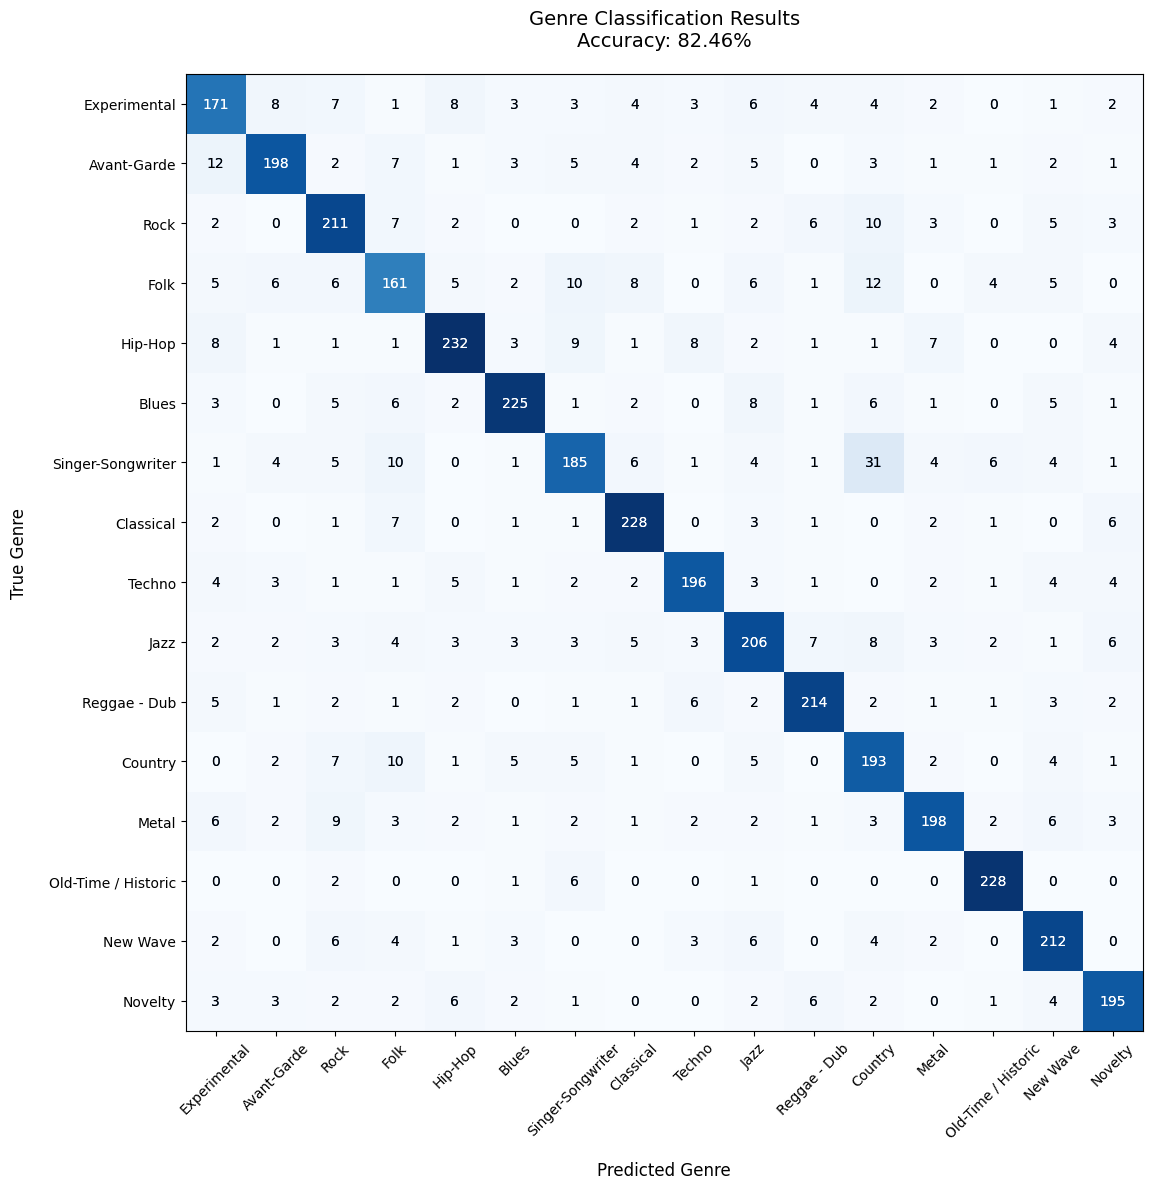


Class-wise Performance:
Experimental: 75.33% (227 samples)
Avant-Garde: 80.16% (247 samples)
Rock: 83.07% (254 samples)
Folk: 69.70% (231 samples)
Hip-Hop: 83.15% (279 samples)
Blues: 84.59% (266 samples)
Singer-Songwriter: 70.08% (264 samples)
Classical: 90.12% (253 samples)
Techno: 85.22% (230 samples)
Jazz: 78.93% (261 samples)
Reggae - Dub: 87.70% (244 samples)
Country: 81.78% (236 samples)
Metal: 81.48% (243 samples)
Old-Time / Historic: 95.80% (238 samples)
New Wave: 87.24% (243 samples)
Novelty: 85.15% (229 samples)


In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# ================================================
# Load genre labels FIRST (before any plotting)
# ================================================
with open(JSON_PATH, "r") as fp:
    data = json.load(fp)
    genre_labels = data["mapping"]

# ================================================
# Single Sample Prediction Function
# ================================================
def predict(model, X_mfcc, X_other, y_true, genre_labels):
    # Reshape for batch prediction
    X_mfcc_batch = np.expand_dims(X_mfcc, axis=0)  # Shape: (1, timesteps, mfcc_features)
    X_other_batch = np.expand_dims(X_other, axis=0)  # Shape: (1, other_features_dim)
    
    # Get prediction
    prediction = model.predict([X_mfcc_batch, X_other_batch], verbose=0)
    predicted_label = np.argmax(prediction)
    
    print(f"\nTrue Genre: {genre_labels[y_true]}")
    print(f"Predicted Genre: {genre_labels[predicted_label]}")
    print(f"Confidence: {np.max(prediction) * 100:.2f}%")
    return predicted_label

# ================================================
# Test Prediction Example
# ================================================
sample_idx = 100  # Example index
predict(model, 
        X_mfcc_test[sample_idx], 
        X_other_test[sample_idx], 
        y_test[sample_idx],
        genre_labels)

# ================================================
# Full Test Set Evaluation
# ================================================
# Generate predictions
y_pred = model.predict([X_mfcc_test, X_other_test], verbose=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_labels)
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Enhanced Confusion Matrix Plot
plt.figure(figsize=(14, 12))
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=genre_labels
)
disp.plot(
    cmap='Blues',
    ax=plt.gca(),
    xticks_rotation=45,
    values_format='d',
    colorbar=False
)

# Formatting
plt.title(f"Genre Classification Results\nAccuracy: {accuracy:.2%}", pad=20, fontsize=14)
plt.xlabel("Predicted Genre", fontsize=12, labelpad=15)
plt.ylabel("True Genre", fontsize=12, labelpad=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)

# Add accuracy text
for i in range(len(genre_labels)):
    for j in range(len(genre_labels)):
        plt.text(j, i, conf_matrix[i, j],
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > conf_matrix.max()/2 else "black")

plt.tight_layout()
plt.show()

# Print class-wise accuracy
print("\nClass-wise Performance:")
for i, genre in enumerate(genre_labels):
    idx = y_test == i
    if sum(idx) > 0:  # Avoid division by zero
        acc = accuracy_score(y_test[idx], y_pred_labels[idx])
        print(f"{genre}: {acc:.2%} ({sum(idx)} samples)")

In [3]:
import json
import os
import math
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tqdm import tqdm
import json
import os
import math
import librosa

In [2]:
import pandas as pd

# Track counts per genre
genre_counts = {
'Experimental'           :7203,
'Avant-Garde'            :2931,
'Rock'                   :2229,
'Folk'                   :2177,
'Hip-Hop'                :2025,
'Blues'                   :662,
'Singer-Songwriter'       :654,
'Classical'               :563,
'Techno'                  :560,
'Jazz'                    :511,
'Reggae - Dub'            :297,
'Country'                 :293,
'Metal'                   :285,
'Old-Time / Historic'     :187,
'New Wave'                :176,
'Novelty'                  :87,
}

# Target number of tracks per genre
target_tracks = 100


# Calculate multiplier for each genre
multipliers = {genre: target_tracks / count for genre, count in genre_counts.items()}

# Display the result
multipliers_df = pd.DataFrame(list(multipliers.items()), columns=["Genre", "Multiplier"])
print(multipliers_df)


                  Genre  Multiplier
0          Experimental    0.013883
1           Avant-Garde    0.034118
2                  Rock    0.044863
3                  Folk    0.045935
4               Hip-Hop    0.049383
5                 Blues    0.151057
6     Singer-Songwriter    0.152905
7             Classical    0.177620
8                Techno    0.178571
9                  Jazz    0.195695
10         Reggae - Dub    0.336700
11              Country    0.341297
12                Metal    0.350877
13  Old-Time / Historic    0.534759
14             New Wave    0.568182
15              Novelty    1.149425
